In [7]:
cwd = "/Users/jonathanlin/Documents/GitHub/research_transfer/"
csv_path = cwd + "datasets/Animal_Kingdom/action_recognition/annotation/val.csv"

import pandas as pd
import PIL
import random
from PIL import Image
import requests
from transformers import Blip2Processor, Blip2ForConditionalGeneration
import torch

In [8]:
df = pd.read_excel("/Users/jonathanlin/Documents/GitHub/research_transfer/datasets/Animal_Kingdom/action_recognition/annotation/df_action.xlsx")
landmarks_frame = pd.read_csv(csv_path, delimiter = " ")

processor = Blip2Processor.from_pretrained("Salesforce/blip2-opt-2.7b")
caption_model = Blip2ForConditionalGeneration.from_pretrained(
    "Salesforce/blip2-opt-2.7b", torch_dtype=torch.float32
)

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/transformers/generation/utils.py:1346: UserWarning: Using `max_length`'s default (20) to control the generation length. This behaviour is deprecated and will be removed from the config in v5 of Transformers -- we recommend using `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


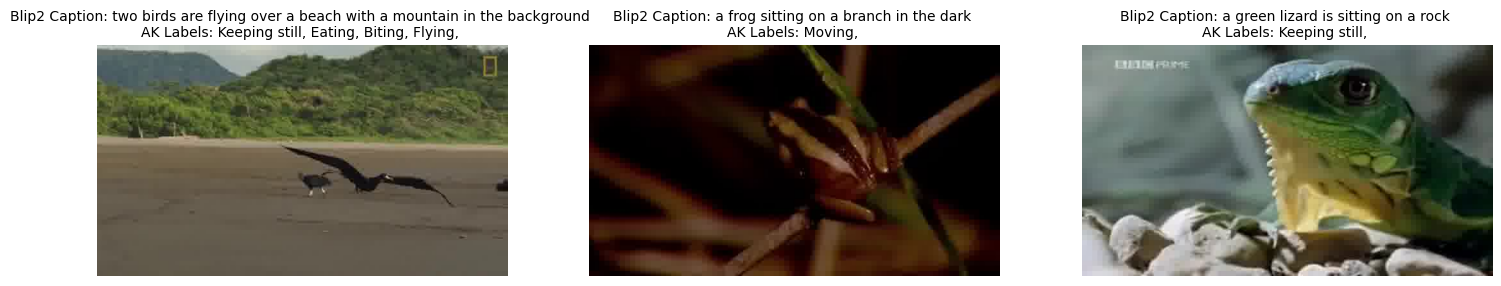

In [9]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

for i in range(3):
    actions = []

    sample_index = random.randint(0, landmarks_frame.shape[0])

    img_path = landmarks_frame.iloc[sample_index, 3]

    # get the action labels
    action_labels = landmarks_frame.iloc[sample_index, 4].split(",")
    for j in range(len(action_labels)):
        action_labels[j] = int(action_labels[j])

    for action in action_labels:
        actions.append(df.at[action, "action"])

    image = PIL.Image.open(cwd + "datasets/Animal_Kingdom/action_recognition/dataset/image/" + img_path, mode="r")
    inputs = processor(images=image, return_tensors="pt").to(torch.float32)
    generated_ids = caption_model.generate(**inputs)
    generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0].strip()

    # Load the image from the .jpg file
    image_path = cwd + "datasets/Animal_Kingdom/action_recognition/dataset/image/" + img_path
    image = mpimg.imread(image_path)

    # show the image
    axes[i].imshow(image)

    # process the action labels to be more readable
    action_text = ""
    for j, action in enumerate(actions):
        if j > 0 and j % 4 == 0:
            action_text += "\n"
        action_text += action + ", "

    # Add a title to the image
    title = f"Blip2 Caption: {generated_text} \nAK Labels: {action_text}"
    axes[i].set_title(title, fontsize=10)

for ax in axes:
    ax.axis('off')
plt.show()